In [1]:
###################
# IMPORT PACKAGES #
###################

import numpy as np
import pandas as pd
import pickle as pkl
import csv
import time

In [2]:
###############
# THE DATASET #
###############

# Import the data
WHO_data = pd.read_csv('web_download_data_WHO.csv')

In [3]:
################
# DATA SHAPING #
################

# Pivot dataframe to create columns based on IND_NAME
WHO_data_pivot = WHO_data.pivot(index=['DIM_GEO_NAME'],
                        columns=['IND_NAME','DIM_1_CODE'], values='VALUE_NUMERIC')

WHO_data = WHO_data_pivot.reset_index()

# Flatten multi-index pivot into dataframe
WHO_data.columns = WHO_data.columns.to_flat_index()
WHO_data.columns = ['_'.join(str(col) for col in multi_col) for multi_col in WHO_data.columns]

# Import CSV file as dictionary, used to rename long column names
def csv_to_dict_no_header(filename):
    """Imports a two-column CSV file into a dictionary.

    Args:
        filename (str): The filename of the CSV file.

    Returns:
        dict: A dictionary where the first column is the key and the second is the value.
    """
    data_dict = {}
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
           if row:  # Ensure the row is not empty
                key = row[0]
                value = row[1]
                data_dict[key] = value
    return data_dict

filename = 'WHO_data_1_columns_dict.csv'
data_as_dict = csv_to_dict_no_header(filename)

WHO_data.rename(columns=data_as_dict, inplace=True)

# Create 'Life_expectancy_category' column
condition1 = (WHO_data['Life_expect_at_brth_yrs_BTSX'] <= 65)
condition2 = ((WHO_data['Life_expect_at_brth_yrs_BTSX'] > 65)
  & (WHO_data['Life_expect_at_brth_yrs_BTSX'] <= 75))
condition3 = (WHO_data['Life_expect_at_brth_yrs_BTSX'] > 75)

value1 = 'Low'
value2 = 'Medium'
value3 = 'High'
defaultvalue = 'NaN'

WHO_data['Life_expectancy_category'] = np.select([condition1, condition2,
                                               condition3],
                                                [value1, value2, value3],
                                              default=defaultvalue)

WHO_data = WHO_data.fillna(0)

# Remove records with Life_expectancy_category == NaN
WHO_data = WHO_data[WHO_data['Life_expectancy_category'] != 'NaN']

# Drop column Life_expect_at_brth_yrs_BTSX, used in creating Life_expectancy_category
WHO_data = WHO_data.drop(columns=['Life_expect_at_brth_yrs_BTSX'])

# Check for missing values
print('\nDisplay missing values:')
display(WHO_data.isna().sum())

# Drop columns with high correlation to target variable to remove impact on feature importance
WHO_data = WHO_data.drop(columns=['Life_expect_at_brth_yrs_MLE',
                       'Life_expect_at_brth_yrs_FMLE',
                       'Healthy_life_expect_at_birth_yrs_BTSX',
                       'Healthy_life_expect_at_birth_yrs_MLE',
                       'Healthy_life_expect_at_birth_yrs_FMLE'],
              )


Display missing values:


,0
DIM_GEO_NAME_,0
Adlcnt_birth_rate_per1k_wm_agrp_yr_15_19,0
Adlcnt_birth_rate_per1k_wm_agrp_yr_10_14,0
Age_std_mort_rt_hhold_ambnt_air_poltn_100K_BTSX,0
Age_std_prev_hyptsn_adlts_age_30-79_yr_pct_BTSX,0
...,...
Pct_tot_antbtc_csmpt_frm_AWaRe_Accs_antbc_cat_pct,0
Cnct_cov_trtmt_srv_drug_use_disodr_pct,0
Prop_hlth_fact_cor_relv_esntl_med_avail_affrd_sust_bsis_pct,0
Pct_15yr_grls_rcvd_rcmmd_dose_HPV_vac_FMLE,0


/tmp/ipython-input-739089958.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(WHO_data, x='Age_std_prev_hyptsn_adlts_age_30-79_yr_pct_BTSX',


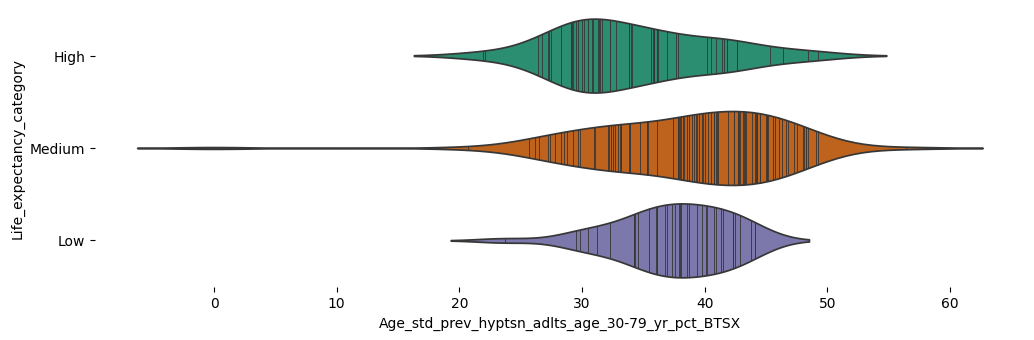

In [4]:
# @title Life_expectancy_category vs Age_std_prev_hyptsn_adlts_age_30-79_yr_pct_BTSX
from matplotlib import pyplot as plt
import seaborn as sns

# Define the desired order of 'species' on the y-axis
custom_order = ['High', 'Medium', 'Low']

figsize = (12, 1.2 * len(WHO_data['Life_expectancy_category'].unique()))
plt.figure(figsize=figsize)

sns.violinplot(WHO_data, x='Age_std_prev_hyptsn_adlts_age_30-79_yr_pct_BTSX',
               y='Life_expectancy_category', inner='stick',
               order=custom_order, palette='Dark2')

sns.despine(top=True, right=True, bottom=True, left=True)